# Social Network Simulations and Analysis

## Introduction: Project Goals and Objectives
If you are in a rush, the most important section is the Simulation Section. 

Networks are systems of nodes (often called vertices) and edges that can be used to represent social, technological, biological, and other systems. In mathematics, networks are called graphs, and they have several interesting mathematical properties.

Social networks are a type of network where each node represents an individual person, and each edge represents a social relationship between two people. It is also possible to create social networks where each node represents a group of people, but for my project I will focus on individuals. 

The primary goal of this project is to identify the potential processes by which different social phenomenon occur, specifically the formation of social groups and the emergence of hierarchies of status between individuals. In order to identify these processes I will simulate social network behavior over time using simple predetermined rules and examine the results. 

In order to measure the extent to which groups are formed, I will use a measure called the clustering coefficient which is a measure of the tendency of a nodes connections to be connected to each other. It is measured for each node, so to determine the overall network characteristic I will take the average over all nodes. Similarly for hierarchy I will use a measure called betweenness centrality, which measures the number of shortest paths that pass through a node. I will show the distribution of betweenness centrality to show the level of hierarchy in the network. The details of these measurements will be elaborated on later. 

In [1]:
import matplotlib.pyplot as plt
#used for plotting
import random 
#used to add randomness into simulations
import numpy as np
import numpy, os, random
from PIL import Image, ImageDraw
#used for making network visualizations
import tempfile
import random, decimal
from igraph import *
#used for network generation and measurements
import math
#import cairo

In [34]:
#functions to call now so that you don't get an error later
def graphplot3(net):
    n = len(net.degree())
    #number of nodes
    windowsize=600
    xd=net.vs["x"]
    yd=net.vs["y"]
    im = Image.new('RGB', (windowsize,windowsize), 'white')
    draw = ImageDraw.Draw(im)
    dotsize=10
    #if len(n2.edge_betweenness())>0:
     #   c=max(n2.edge_betweenness())
   # else:
     #   c=1
    center = windowsize/2.
    radius = (1.-2*20)*(n+1)/2.
    #xd, yd = np.arange(0,400,400//n), np.arange(0,400,400//n)
    # Create a dictionary that maps nodes to their positions around the circle
    for i in range(n):
        for j in range(n):
            if (i,j) in net.get_edgelist():
                a=net.get_eid(i,j)
                draw.line(((xd[i],yd[i]), (xd[j],yd[j])),fill=(net.es["color"][a]))
    for i in range(n):
         draw.ellipse( ((xd[i]-dotsize/2, yd[i]-dotsize/2),
                       (xd[i]+dotsize/2, yd[i]+dotsize/2)), fill=(net.vs["color"][i]))
    return im

def distributions(net,bins2):
    y=net.degree()
    z=net.edge_betweenness()
    w=net.eigenvector_centrality(directed=False, scale=True)
    plt.hist(y,bins='auto');
    plt.title("Distribution of Node Degrees")
    plt.show()
    plt.hist(z,bins='auto');
    plt.title("Distribution of Edge Betweenness")
    plt.show()
    plt.hist(w,bins=bins2);
    plt.title("Distribution of Node Eigenvector Centrality")
    plt.show()
    
def modularity(net):
    n = len(net.degree())
    b=net.community_optimal_modularity()
    modules = len(b)
    x=np.zeros(n)
    for i in range(modules):
        a=len(b[i])
        for j in range(a):
            x[b[i][j]]=i
    return [net.modularity(x, weights=None), modules]

## Starting from Scratch
Initially I created an object class for networks and began graphing the networks and writing code to measure the network characteristics. However, as the networks became larger and more complex, my code became too slow, so I decided to start using the python igraph package which has optimized algorithms for creating and measuring networks. Here is the code that I started with. 

In [3]:
#defines a class for networks
class Network(object):
    def __init__(self, edges=None, id=None,loc=None, cent=None,col=None,size=None):
        self.edges = edges
        #attribute contains the edges of the graph as a matrix 
        #where Aij is one if there is an edge connecting nodes i and j, and 0 if there isnt
        self.id = id
        #this is a list of id's of the nodes, ranging from 0 to n-1
        self.loc = loc
        #this is the coordinates of each node, each node has an x and y coordinate
        #self.cent = cent
        self.col = col
        #this is the color of each node
        self.size = size
        #this is the size of each node

Notes: There are a few ways to represent edges in a network. My initial method was to represent them as a sqaure matrix A of dimensions N by N where N is the number of node. If $A_{ij}$ is one, it means there is an edge between nodes i and j, if it is 0 it means there is not an edge between them. In some networks, edges have directions, meaning an edge going from node i to node j is different from an edge going from node j to node i. This would mean $A_{ij}$ does not equal $A_{ji}$. This type of network is called a directed network, since the edges have a direction. Another type of network is an undirected network, where an edge from node i to node j is the same as a node going from node j to node i. In this type of network, $A_{ij}$ must equal $A_{ji}$ for all points in the edge matrix. In my project I will ONLY be dealing with UN-directed networks, so the matrix must be symmetric about $A_{ii}$ for i in N. In some networks, it is possible for a node to have an edge with itself, called a loop. This would mean $A_{ii}$ would equal 2 for an undirected looped node, and 1 for a directed looped node. However, my networks will not contain loops, so the points $A_{ii}$ will always be zero. 

The package igraph does not use an edge matrix. Instead it takes edges in the form of coordinates (node1, node2), and each edge has an id corresponding to when it was added to the network. It is important to note that igraph assumes that edges are undirected unless it is specified. 


In [3]:
def createnetwork(N):
    edges=np.zeros((N,N))
    #no edges initially
    id=np.arange(N)
    loc = np.arange(0,50*N,50),np.arange(0,50*N,50)
    #sequential locations
    cent=np.zeros(N)
    col=['red']*N
    size=1
    return Network(edges,id,loc,cent,col,size)
#this creates a simple network with n nodes and no edges

In [4]:
def createnetwork2(N):
    edges=np.zeros((N,N))
    id=np.arange(N)
    radius=150
    center=200
    loc=[None]*N,[None]*N
    for index in range(N):
        theta = 2.*numpy.pi*float(index)/N
        loc[0][index] = radius * numpy.cos(theta) + center
        loc[1][index] = radius * numpy.sin(theta) + center
    #the locations are in a circle instead
    cent=np.zeros(N)
    col=['red']*N
    size=1
    return Network(edges,id,loc,cent,col,size)
#this creates a simple network where the network is in a circle instead

In [33]:
def basicgraphplot(net):
    n = len(net.id)
    #size of network
    windowsize=400
    im = Image.new('RGB', (windowsize,windowsize), 'white')
    draw = ImageDraw.Draw(im)
    dotsize=net.size*10
    color = net.col
    center = windowsize/2.
    radius = (1.-2*20)*(n+1)/2.
    xd=net.loc[0]
    yd=net.loc[1]
    # Create a dictionary that maps nodes to their positions around the circle
    for i in range(n):
        for j in range(n):
            if net.edges[i,j]>0:
                draw.line(((xd[i],yd[i]), (xd[j],yd[j])),fill=(0,0,0))
    for i in range(n):
         draw.ellipse( ((xd[i]-dotsize/2, yd[i]-dotsize/2),
                       (xd[i]+dotsize/2, yd[i]+dotsize/2)), fill=net.col[i] )
    return im
#this function draws the nodes and edges with the given locations and colors

In [58]:
net1=createnetwork2(10)

In [40]:
#simple network simulation 
#select random pair, if a random decimal is greater than p, make an edge
def networksimulation1(net,iterations, p):
    l=[]
    n = len(net.id)  
    lis=net.id
    for i in range(iterations):
        sel=[random.random() for i in range(n)]
        for i in range(n):
            if sel[i]<p:
                sel[i]=1
            else: 
                sel[i]=0
        random.shuffle(lis)
        for j in range(n//2):
            if sel[j]==1:
                net.edges[int(lis[2*j])][int(lis[2*j+1])]=1
                net.edges[int(lis[2*j+1])][int(lis[2*j])]=1
                #creates edge if the random decimal is greater than the probability
    return net

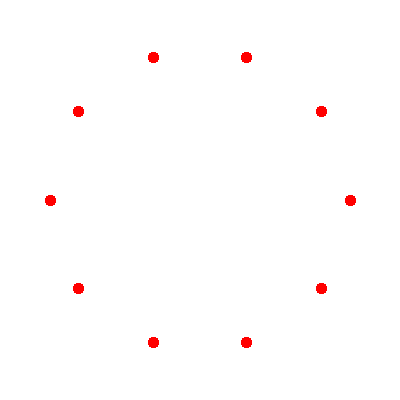

In [59]:
basicgraphplot(net1)

In [60]:
networksimulation1(net1,8,0.3)

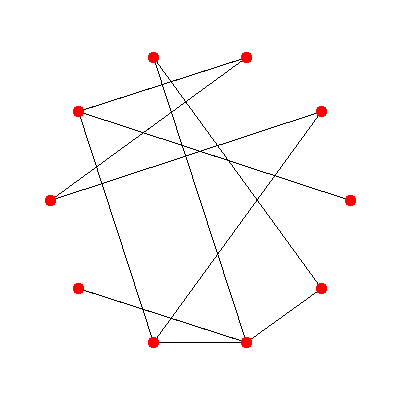

In [61]:
basicgraphplot(net1)

This simple network simulation takes a network and creates edges through this process:
1. For each iteration, take the list of nodes, and shuffle it.
2. Take this shuffled list and divide it into pairs. 
3. Generate a random decimal for each pair. 
4. If the decimal is less than the specified probability, then create an edge between the two nodes. If not, do nothing. 
5. Return the network after the specified number of iterations. 

This algorithm creates edges randomly. If the probability is low, then few edges will be made each iteration, and if it is high then many edges will be made each iteration. 

### Measurements: Shortest Path
The shortest path between two nodes is the the shortest number of edges needed to connect two nodes. This measurement can tell us how well connected two nodes are: a low shortest path is well connected and a high shortest path is poorly connected. The average shortest path of a network tells us how well connected the overall network is. 

The shortest path can also be used to find the betweenness centrality of a node. The betweenness centrality of node a is defined as the sum of the ratio of the number of shortest paths that pass through a over the number of shortest paths in total for each possible pair of nodes that does not contain a. This measurement tells us how necessary node a is in bridging other nodes efficiently. I originally wanted to use the betweenness centrality as a measure of social status, but it is a computationally complex measure, so I opted for the eigenvector centrality instead. 

In [48]:
#this is an algorithm for calculating the shortest path between two nodes
def find_shortest_path(edges, start, end, path=[]):
        path = path + [start]
        #start with an list containing the starting point
        if start == end:
            #if the starting point is the end point, you have found the shortest path
            return path
        if int(sum(edges[int(start)]))==0:
            #if the starting point has no edges, there is no shortest path
            return None
        shortest = None
        l=[]
        #create dummy list
        for i in range(len(edges)):
            if edges[int(start)][i]>0:
                l.append(i)
                #for the nodes that are connected to the start, add to l
        for node in l:
            #for all of the nodes connected to l, if the node isnt in the path, 
            #run this function again starting at the new node
            if node not in path:
                newpath = find_shortest_path(edges, node, end, path)
                if newpath:
                    #if the newpath is the shortest, rename it shortest
                    if not shortest or len(newpath) < len(shortest):
                        shortest = newpath
        return shortest #returns shortest path
#https://www.python.org/doc/essays/graphs/

In [63]:
find_shortest_path(net1.edges,9,6, path=[])

[9, 3, 6]

The shortest path is returned as a list of the nodes connecting the starting and ending nodes. 

In [103]:
net2=createnetwork2(50)

In [104]:
networksimulation1(net2,30,0.08)

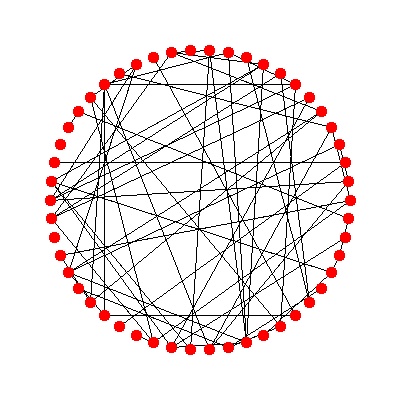

In [105]:
basicgraphplot(net2)

In [107]:
find_shortest_path(net2.edges,41,11, path=[])

[41, 25, 43, 8, 11]

For a graph that has only 50 nodes and a 30 iterations at 0.08 probability, the calculation of the shortest path for one pair of nodes is already computationally difficult. This means that the betweenness centrality and other measures requiring the shortest path are not practical for larger networks with more edges. 

## Python igraph: A Library for Graphs and Networks
Instead of coding the algorithms for creating and measuring graphs myself, I decided to use the library igraph, which has a built in class for graphs/networks, as well as many functions for measuring networks. 

Here are the basic functions of igraph:
1. g=Graph() creates an empty graph named g
2. g.summary() gives a summary of the graph, the output is the number of nodes followed by the number of edges 
2. g.add_vertices(n) adds n vertices to the graph 
3. g.add_edges([(edge 1 coordinates),...(edge n coordinates)]) adds n edges of the given coordinates. If a new edge is added to the network, it is put at the end of the edge list 
4. g.get_eid(a,b) gives the position of the edge connecting nodes a and b in the edge list
5. g.get_eid() gives the list of edges of graph g
  
There are many measurements that can be made in igraph relatively quickly, which makes it useful for determining the network characteristics. One of the most basic measurements is node degree, which is the number of edges connected to a node. In terms of social networks, this can be thought of simply as a measure of an individuals popularity. 

An important characteristic of edges is the edge betweenness, which is basically the same as betweenness centrality but it is calculated for edges rather than nodes. igraph calculates the edge betweenness very quickly. 

Another important measure is the eigenvector centrality of a node. The eigenvector centrality of a node is the sum of the eigenvector centralities of the nodes it is connected to multiplied by a constant. In effect, a node with a high eigenvector centrality is well connected and/or connected to nodes that are well connected. It can be calculated by setting every node's eigenvector centrality to 1, and then updating the centrality iteratively based on the formula until the values have stabilized. 

One way to measure the existence of groups is the modularity. The modularity of a graph is the fraction of edges that fall within a previously specified set of groups minus the expected fraction if edges were determined randomly. The modularity ranges from -1 to 1, where a modularity greater than 0.3 means that the groups are pretty significantly tied together. In order to determine the modularity, the groups of the network must be determined first. Determining groups for a network is mathematically complex task, but igraph has a built in function for determining the optimal set of groups in a network. 

Here are the functions for making the measurements above:
1. g.degree() gives a list of the degrees of each node, which is the number of edges connected to a node. This is useful for many measurements.
2. g.edge_betweenness() returns a list of the edge betweenness for every edge
3. g.eigenvector_centrality(directed=False, scale=True) gives a list of the eigenvector centralities of each node. Scale = True normalizes the values to 1 and directed=False confirms that the network is undirected. 
4. g.community_optimal_modularity() gives the optimal list of the groups within the network, where the groups list the id's of each node. This function is useful for small networks (n<100) but is slow for networks that are larger than 100 and networks with many edges. 
5. g.modularity(x, weights=None) calculates the modularity of a network for a list of groups x. Weights are not used in the project, so weights=None. Using this function along with the one above allows us to calculate the groups and modularity of a network without knowing anything about the groups beforehand. 

Helpful igraph documentation:
1. https://igraph.org/python/doc/igraph.Graph-class.html
2. https://igraph.org/python/doc/tutorial/tutorial.html


In [35]:
n1=Graph()
n1.add_vertices(3)
n1.add_edges([(2,1),(0,1)])

In [36]:
n1.get_edgelist()

[(1, 2), (0, 1)]

In [37]:
n1.summary()

'IGRAPH U--- 3 2 -- '

In [38]:
n1.get_eid(2,1)

0

In [39]:
n1.degree()

[1, 2, 1]

For plotting graphs using igraph, it useful to create a list of the x and y coordinates of the network and add them as an attribute to the network and then plot them using this information. igraph allows for the addition of attributes to networks. These attributes are unique to the individual networks. They can be attributes related to the nodes or to the vertices. 

The command for adding network attributes is:
1. g.vs["attribute name"]=[list of attributes for each node] for nodes
2. g.es["attribute name"]=[list of attributes for each edge] for edges

In [40]:
n2=Graph()

In [41]:
n2.add_vertices(50)

In [42]:
n2.summary()

'IGRAPH U--- 50 0 -- '

In [43]:
x=[]
y=[]
for i in range(50):
        theta = 2.*np.pi*float(i)/50
        x.append(150 * np.cos(theta) + 200)
        y.append(150 * np.sin(theta) + 200)
#this is a simple set of circular coordinates

In [44]:
edgecolors=['blue']*50
nodecolors=['red']*50
#sets a list for the colors of the edges and nodes

In [45]:
n2.vs["x"]=x
n2.vs["y"]=y
n2.vs["color"]=nodecolors
n2.es["color"]=edgecolors
#this sets the x, y, and color attributes for the network

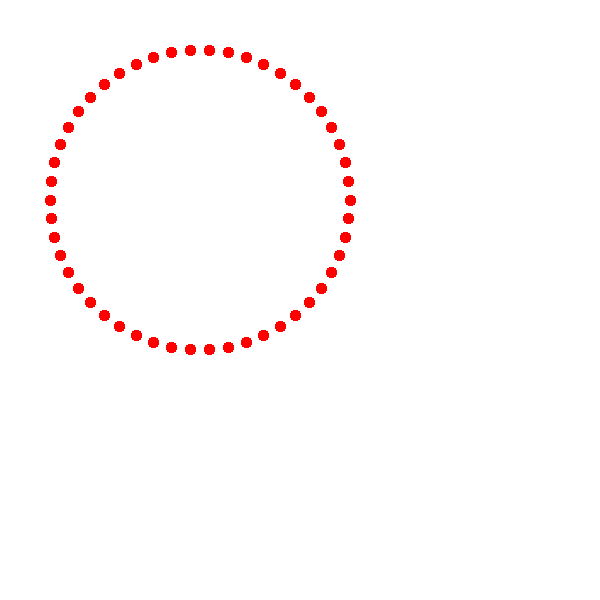

In [46]:
graphplot3(n2)

## Random Networks
igraph has several algorithms for creating random networks. One popular random network is the Erdos-Renyi method. For this method, the number of nodes is specified and then random edges are generated in one of two ways. The first is by specifying a probability, where every possible edge is created with the specified probability. Alternatively, the number of desired edges m can be specified and the edges are selected randomly among the possible edges. 

Another random network generator I will be using is Random Geometric Graph method. The function Graph.GRG(nodes,d) creates a random geomtric graph through a geographic algorithm. The algorithm works as follows:
1. Give each nodes an id number
2. For each node assign a random set of x and y coordinates within a unit square
3. For nodes within distance d of each other, create an edge between the two nodes.  


In [47]:
n3=Graph.Erdos_Renyi(50, 0.05, directed=False, loops=False)
#a network of fifty nodes, and edges chosen with probability p, undirected and no loops

In [48]:
n3.vs["x"]=x
n3.vs["y"]=y
n3.vs["color"]=nodecolors
n3.es["color"]=edgecolors
#this sets the x and y attributes for the network

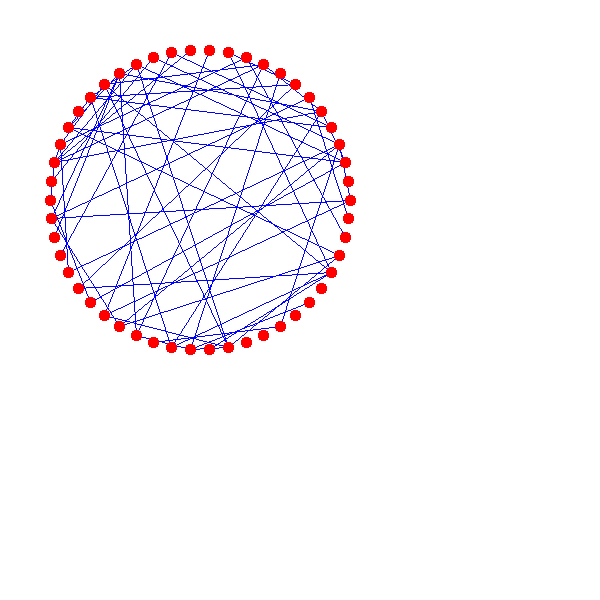

In [49]:
graphplot3(n3)

In [19]:
summary(n3)

IGRAPH U--- 50 60 -- 
+ attr: color (v), x (v), y (v), color (e)


In [92]:
n4=CreateGeo(50,0.2)

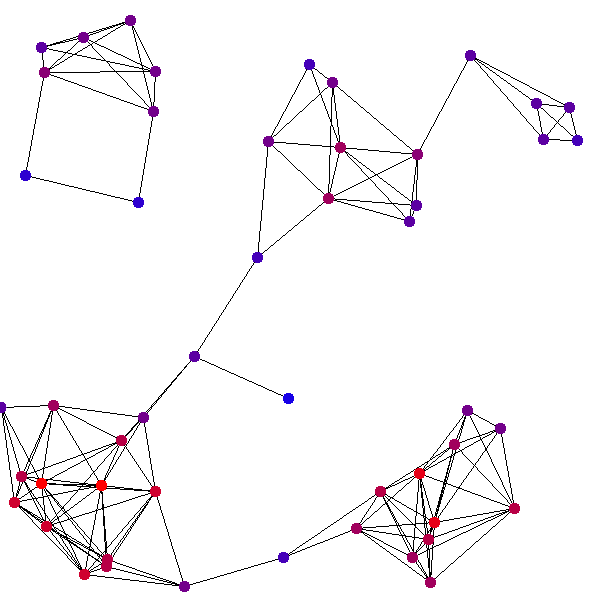

In [93]:
graphplot3(n4)

In [17]:
summary(n4)

IGRAPH U--- 50 47 -- 
+ attr: color (v), x (v), y (v), color (e)


We can plot a distribution of network characteristics such as degree, edge betweenness, and eigenvector centrality. This helps us see how random graphs behave.

If we create a larger graph, we can see that the distributions tend to be normal for the Erdos-Renyi model, but not for the geographic algorithm. The random geometric graph seems to follow more of a chi-square distribution for the degree and edge betweenness, and a power law for the eigenvector centrality. This is because the geographic algorithm is biased in that collections of edges are likely to be connected because they were geographically close. This creates specific groups and also make nodes that happened to fall in the center more well connected to the rest of the group since they fall between each of the edges. While the geographic algorithm is random, the distributions are not normal, so it is more useful to compare future networks to the Erdos-Renyi netowrk. 

In [3]:
def distributions(net,bins2):
    y=net.degree()
    z=net.edge_betweenness()
    w=net.eigenvector_centrality(directed=False, scale=True)
    plt.hist(y,bins='auto');
    plt.title("Distribution of Node Degrees")
    plt.show()
    plt.hist(z,bins='auto');
    plt.title("Distribution of Edge Betweenness")
    plt.show()
    plt.hist(w,bins=bins2);
    plt.title("Distribution of Node Eigenvector Centrality")
    plt.show()

In [19]:
n5=Graph.Erdos_Renyi(500, 0.05, directed=False, loops=False)
n6=Graph.GRG(250,0.05)

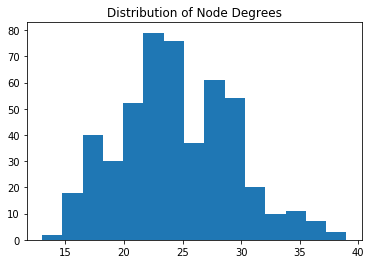

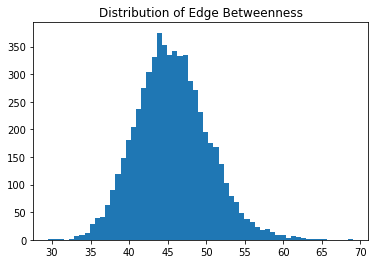

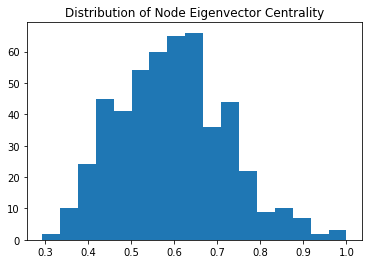

In [20]:
distributions(n5,'auto')

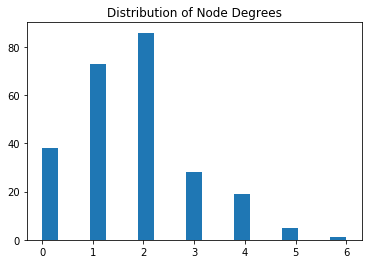

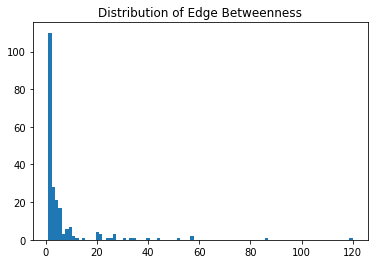

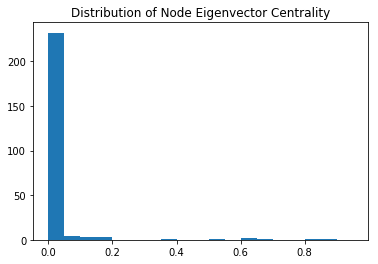

In [21]:
bins=(np.arange(0,1,0.05))
distributions(n6,bins)

## Simulating Social Networks
The primary goal of this project is to simulate social networks using simple rules and to see whether the emergent properties of the simulations match observed properties of social networks. 

These simulations will be based off of the following social concepts:
1. Proximity: people who are physically closer to each other tend to form relationships more easily. A good measure of proximity is geographic location distance.  
2. Popularity: people who are more popular tend to have an easier time making more friends, while people who are not popular tend to struggle making more friends (obviously this is an oversimplification but this is how I made the model). A good measure of popularity is degree, which is the number of nodes that a node is connected to. 
3. Influence: people with influence tend to be drawn to other people with influence. Influence tends to increase proportionally to the amount an individual has (also oversimplifaction). A good measure of influence is the eigenvector centrality of a node, or the betweenness centrality. 
4. Dunbar's Number: There is a limit to the number of significant relationships an individual can have, called Dunbar's Number (https://en.wikipedia.org/wiki/Dunbar%27s_number). It lies somewhere around 150, however my networks are relatively small so I might make dunbar's number smaller. Dunbar's Number sets a maximum for the degree of a node. 

First we must create a network to simulate. Initially the network will have no edges and the locations of the nodes will be in a circle. The color of the edges will be based on the betweenness centrality of the edges, which starts at 1. The color of the nodes will be based on the degree which starts at 0 for each node. This will show some of the network characteristics within the graph. 

### Creating Initial Graphs to Simulate

Creating a Random Graph using the Erdos Renyi method.

In [3]:
def CreateErdos(n,p):
    net=Graph.Erdos_Renyi(n, p, directed=False, loops=False)
    #Graph(n)
    #random coordinates
    x=[]
    y=[]
    x=np.arange(0,400,400/n)
    y=np.arange(0,400,400/n)
    random.shuffle(x)
    random.shuffle(y)
    nodecolors=[0]*n
    if max(net.degree())>0:
        d=max(net.degree())
    else:
        d=1
    if len(net.edge_betweenness())>0:
        c=max(net.edge_betweenness())
    else:
        c=1
    for i in range(n):
        nodecolors[i]=(int(254*net.degree()[i]/d),0,int(255-254*net.degree()[i]/d ))
    edgecolors=[0]*len(net.get_edgelist())
    for i in range(n):
            for j in range(n):
                if (i,j) in net.get_edgelist():
                    a=net.get_eid(i,j)
                    b=net.edge_betweenness()[a]/c
                    edgecolors[i]=(int(140-b*140),int(b*140),255)  
    net.vs["x"]=x
    net.vs["y"]=y
    net.vs["color"]=nodecolors
    net.es["color"]=edgecolors
    return net

Creating an empty network. 

In [4]:
def CreateEmpty(n):
    net=Graph(n)
    #Graph(n)
    #random coordinates
    x=[]
    y=[]
    x=np.arange(600/n,600,600/n)
    y=np.arange(600/n,600,600/n)
    random.shuffle(x)
    random.shuffle(y)
    nodecolors=[0]*n
    edgecolors=[0]*len(net.get_edgelist())
    if max(net.degree())>0:
        d=max(net.degree())
    else:
        d=1
    if len(net.edge_betweenness())>0:
        c=max(net.edge_betweenness())
    else:
        c=1
    for i in range(n):
        nodecolors[i]=(int(254*net.degree()[i]/d),0,int(255-254*net.degree()[i]/d ))
    for i in range(n):
            for j in range(n):
                if (i,j) in net.get_edgelist():
                    a=net.get_eid(i,j)
                    b=net.edge_betweenness()[a]/c
                    edgecolors[i]='red'#(int(140-b*140),0,0)  #int(b*140)
    net.vs["x"]=x
    net.vs["y"]=y
    net.vs["color"]=nodecolors
    net.es["color"]=edgecolors#edgecolors
    return net

Creating a Geometric Random Network

In [3]:
def CreateGeo(n,d):
    net=Graph.GRG(n,d)
    nodecolors=[0]*n
    edgecolors=[0]*len(net.get_edgelist())
    net.vs["x"]=[float(x*590) for x in net.vs["x"]]
    net.vs["y"]=[float(y*590) for y in net.vs["y"]]
    if max(net.degree())>0:
        d=max(net.degree())
    else:
        d=1
    if len(net.edge_betweenness())>0:
        c=max(net.edge_betweenness())
    else:
        c=1
    for i in range(n):
        nodecolors[i]=(int(254*net.degree()[i]/d),0,int(255-254*net.degree()[i]/d ))
        '''for i in range(n):
            for j in range(n):
                if (i,j) in net.get_edgelist():
                    a=net.get_eid(i,j)
                    b=net.edge_betweenness()[a]/c
                    edgecolors[i]=(int(140-b*140),int(b*140),255) ''' 
    net.vs["color"]=nodecolors
    net.es["color"]=edgecolors
    return net

Creating an Empty Network with circular coordinates

In [6]:
def CreateCircular(n):
    net=Graph(n)
    #Graph(n)
    #random coordinates
    x=[]
    y=[]
    for i in range(n):
        theta = 2.*np.pi*float(i)/n
        x.append(150 * np.cos(theta) + 200)
        y.append(150 * np.sin(theta) + 200)
    nodecolors=[0]*n
    edgecolors=[0]*len(net.get_edgelist())
    if max(net.degree())>0:
        d=max(net.degree())
    else:
        d=1
    if len(net.edge_betweenness())>0:
        c=max(net.edge_betweenness())
    else:
        c=1
    for i in range(n):
        nodecolors[i]=(int(254*net.degree()[i]/d),0,int(255-254*net.degree()[i]/d ))
    for i in range(n):
            for j in range(n):
                if (i,j) in net.get_edgelist():
                    a=net.get_eid(i,j)
                    b=net.edge_betweenness()[a]/c
                    edgecolors[i]=(int(140-b*140),int(b*140),255)  
    net.vs["x"]=x
    net.vs["y"]=y
    net.vs["color"]=nodecolors
    net.es["color"]=edgecolors
    return net

Creating a Connected Circular Graph

In [7]:
def CreateConCirc(n):
    net=Graph(n)
    #Graph(n)
    #random coordinates
    '''x=[]
    y=[]
    for i in range(n):
        theta = 2.*np.pi*float(i)/n
        x.append(200 * np.cos(theta) + 300)
        y.append(200 * np.sin(theta) + 300)'''
        
    x=[]
    y=[]
    x=np.arange(600/n,600,600/n)
    y=np.arange(600/n,600,600/n)
    random.shuffle(x)
    random.shuffle(y)
    
    nodecolors=[0]*n
    edgecolors=[0]*len(net.get_edgelist())
    if max(net.degree())>0:
        d=max(net.degree())
    else:
        d=1
    if len(net.edge_betweenness())>0:
        c=max(net.edge_betweenness())
    else:
        c=1
    for i in range(n):
        nodecolors[i]=(int(254*net.degree()[i]/d),0,int(255-254*net.degree()[i]/d ))
    net.add_edges([(0,n-1)])
    for j in range(n-1):
        net.add_edges([(j,j+1)])
    """for i in range(n):
            for j in range(n):
                if (i,j) in net.get_edgelist():
                    a=net.get_eid(i,j)
                    b=net.edge_betweenness()[a]/c
                    edgecolors[i]=(int(140-b*140),int(b*140),255)  """
    net.vs["x"]=x
    net.vs["y"]=y
    net.vs["color"]=nodecolors
    net.es["color"]='red'#edgecolors
    return net

In [8]:
def resetcolors(net):
    n=len(net.degree())
    nodecolors=[0]*n
    if max(net.degree())>0:
        d=max(net.edge_betweenness())
    else:
        d=1
    if len(net.edge_betweenness())>0:
        c=max(net.edge_betweenness())
    else:
        c=1
    for i in range(n):
        nodecolors[i]=(int(254*net.degree()[i]/d),0,int(255-254*net.degree()[i]/d ))
    edgecolors=[0]*len(net.get_edgelist())
    for i in range(n):
            for j in range(n):
                if (i,j) in net.get_edgelist():
                    a=net.get_eid(i,j)
                    b=net.edge_betweenness()[a]/c
                    edgecolors[i]=(int(140-b*140),int(b*140),0)
    net.vs["color"]=nodecolors
    net.es["color"]=edgecolors
    return net, print(edgecolors[19])

In [9]:
def graphplot3(net):
    n = len(net.degree())
    #number of nodes
    windowsize=600
    xd=net.vs["x"]
    yd=net.vs["y"]
    im = Image.new('RGB', (windowsize,windowsize), 'white')
    draw = ImageDraw.Draw(im)
    #draw.line((0,250, 250,600), fill=128)
    dotsize=15
    #if len(n2.edge_betweenness())>0:
     #   c=max(n2.edge_betweenness())
   # else:
     #   c=1
    center = windowsize/2.
    radius = (1.-2*20)*(n+1)/2.
    #xd, yd = np.arange(0,400,400//n), np.arange(0,400,400//n)
    # Create a dictionary that maps nodes to their positions around the circle
    l=len(net.get_edgelist())
    for j in range(l):
        a=net.get_edgelist()[j]
        draw.line(((xd[a[1]],yd[a[1]]), (xd[a[0]],yd[a[0]])),fill=(net.es["color"][j]))
    for i in range(n):
         draw.ellipse( ((xd[i]-dotsize/2, yd[i]-dotsize/2),
                       (xd[i]+dotsize/2, yd[i]+dotsize/2)), fill=(net.vs["color"][i]))
    
    return im

This is used to reset the colors after a simulation. 

### The Simple Proximity Model
This simulation is based on the concept that people who are near each other are more likely to form relationships with each other and the the idea that once relationships are formed, people tend to move closer to each other. The algorithm for this simulation is as follows:
1. For each iteration, randomly select pairs of nodes, where no node is in more than one pair (If the number of nodes is odd, then one node is left out, but it is a random node each time so it doesn't matter).
2. If the nodes of a pair are within a predetermined distance of each other and they have not already formed an edge, then they form an edge. 
3. If the nodes form an edge, the first node in the pair moves towards the other node with a distance that is half of the distance they were apart (This fraction can be changed to see what happens). 
4. Repeat this process for each pair in the iteration and repeat for the specified number of iterations. 

In [10]:
def simulation1(net,it,distance):
    n = len(net.degree())
    for i in range(it):
        a=np.arange(n)
        random.shuffle(a)
        for j in range(n//2):
            b=2*j
            c=2*j+1
            xa=net.vs["x"]
            ya=net.vs["y"]
            x1 = net.vs["x"][a[b]]
            x2 = net.vs["x"][a[c]]
            y1 = net.vs["y"][a[b]]
            y2 = net.vs["y"][a[c]]
            if math.hypot(x2-x1,y2-y1)<distance:
                if (a[b],a[c]) or (a[c],a[b]) not in net.get_edgelist():
                    net.add_edges([(a[b],a[c])])
                xa[a[b]]=(x2-x1)/2 + x1
                ya[a[b]]=(y2-y1)/2 + y1 
                net.vs["x"]=xa
                net.vs["y"]=ya
  #      for k in range(n):          
    return net 

In [111]:
n7 = CreateEmpty(150)

In [113]:
simulation1(n7,150,150)

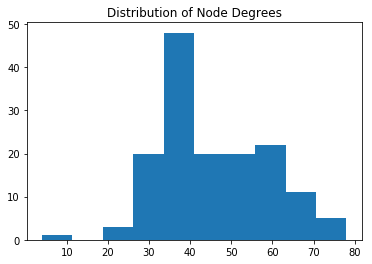

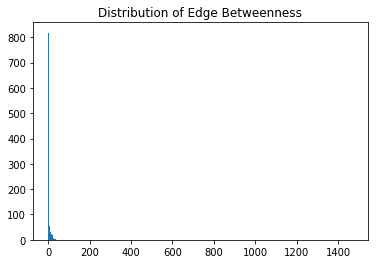

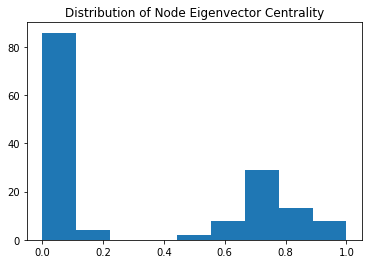

In [114]:
distributions(n7,'auto')

In [35]:
modularity(n7)

[0.709396017119399, 7]

If the number of iterations is high enough (<15 or so) you can begin to see groups form. When the coordinates are circular, the groups tend to appear in some sort of polygon, where the groups form a vertex of the polygon. When the coordinates are random, the groups form at different points of the window and are generally disconnected. 

#### Measuring and Comparing the Simulated Graph
Since the geographic simulation is meant to show groups, I will find the optimal modules of the network and compute the modularity of the network. This can be compared to the modularity of the Erdos-Reyni network. I will also show the distribution of the network characteristics.  

In [11]:
def modularity(net):
    n = len(net.degree())
    b=net.community_optimal_modularity()
    modules = len(b)
    x=np.zeros(n)
    for i in range(modules):
        a=len(b[i])
        for j in range(a):
            x[b[i][j]]=i
    return [net.modularity(x, weights=None), modules]
#this function calculates the modularity of a network 
#by first finding the optimal groups and then calculating the modularity
#it outputs the modularity and the number of groups
#for the geographic simulation, the number of groups should match the visible groups

In [10]:
n7 = CreateEmpty(50)

In [11]:
simulation1(n7,50,150)

In [ ]:
modularity(n7)

In [17]:
n8 = CreateErdos(20,0.1)

In [18]:
modularity(n8)

[0.4112499999999999, 8]

The modularity for the simulated network is usually around 0.64 (for the given network), while the random network modularity is around 0.3. Clearly the simulated network forms much stronger groups of nodes. The flaw with this model is that it exaggerates the distribution of edge betweenness because edges between two groups are given very high importance. In reality, the edge betweeness distribution should be a little more evenly distributed. 

### The Simple Popularity Model
This simulation is based on the concept that people who are popular tend to make social connections more easily than those who are not popular. This simulation will be based on a simple algorithm:
1. For each iteration, select two nodes from a list of the nodes where each node appears in the list as many times as it has edges. This list will be called the degree distribution. 

This algorithm has the effect of making nodes with high degree more likely to increase their degree over each iteration creating a long tailed distribution. 

In [31]:
def PopSimulation(net,it):
    n = len(net.degree())
    deg=net.degree()
    nlist=np.arange(n)
    z = np.concatenate([[i]*deg[i] for i in nlist])
    for i in range(it):
        a=random.choice(z)
        b=random.choice(z)
        net.add_edges([(int(a),int(b))])
        z= np.append(z,a)
        z= np.append(z,b)
    return net

In [32]:
n9 = CreateConCirc(40)

In [34]:
PopSimulation(n9,100)

In [ ]:
modularity(n9)

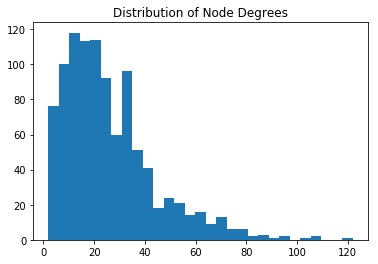

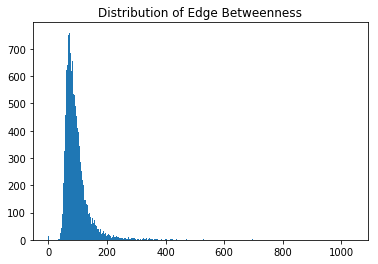

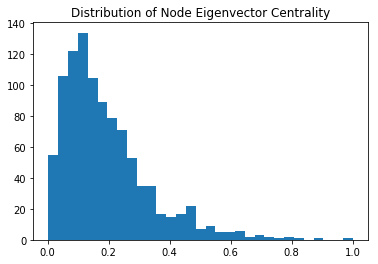

In [61]:
distributions(n9,'auto')

The benefit of this model is that it gives a useful distribution of the eigenvector centrality and edge betweennes because it they have long tails but are more evenly distributed than the Proximity Model

## The Combination Model
For the final simulation I combined the two previous simulations to see if it would display properties from both simulations. The algorithm is as follows:
1. For each iteration, randomly select pairs of nodes, where no node is in more than one pair (If the number of nodes is odd, then one node is left out, but it is a random node each time so it doesn't matter).
2. If the nodes of a pair are within a predetermined distance of each other and they have not already formed an edge, then they form an edge. 
3. If the nodes form an edge, the first node in the pair moves towards the other node with a distance that is half of the distance they were apart (This fraction can be changed to see what happens). 
4. If the nodes do not form an edge, select two new random nodes from the degree distribution and form an edge. 

This simulation combines aspects from the geographical and popularity simulations, so we should expect to see properties from both. 

In [14]:
def ComboSimulation(net,it,distance):
    n = len(net.degree())
    deg=net.degree()
    nlist=np.arange(n)
    z = np.concatenate([[i]*deg[i] for i in nlist])
    for i in range(it):
        a=np.arange(n)
        random.shuffle(a)
        for j in range(n//2):
            b=2*j
            c=2*j+1
            xa=net.vs["x"]
            ya=net.vs["y"]
            x1 = net.vs["x"][a[b]]
            x2 = net.vs["x"][a[c]]
            y1 = net.vs["y"][a[b]]
            y2 = net.vs["y"][a[c]]
            if math.hypot(x2-x1,y2-y1)<distance:
                if (a[b],a[c]) or (a[c],a[b]) not in net.get_edgelist():
                    net.add_edges([(a[b],a[c])])
                else:
                    a=random.choice(z)
                    b=random.choice(z)
                    net.add_edges([(a,b)])
                    z= np.append(z,a)
                    z= np.append(z,b)
                xa[a[b]]=(x2-x1)/2 + x1
                ya[a[b]]=(y2-y1)/2 + y1 
                net.vs["x"]=xa
                net.vs["y"]=ya
  #      for k in range(n):          
    return net 

In [26]:
n10=CreateConCirc(50)
#n can go up to 1000 or so

In [27]:
ComboSimulation(n10,50,100)
#simulations can be up to 5000-10000 without being too slow

In [ ]:
modularity(n10)
#ONLY RUN IF LOW N

In [ ]:
graphplot3(n10)
#only run for n<500 and not too many edges. 

In [44]:
len(n10.get_edgelist())

11000

The simulation for 10,000 iterations at 1,000 nodes takes around 10 seconds to run. The distributions are clearly heavily skewed toward the right. This generally matches observed distributions of influence. 

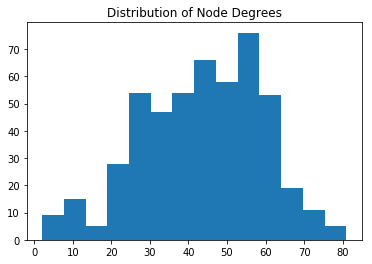

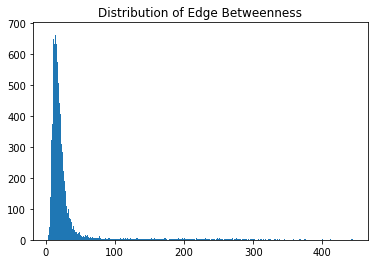

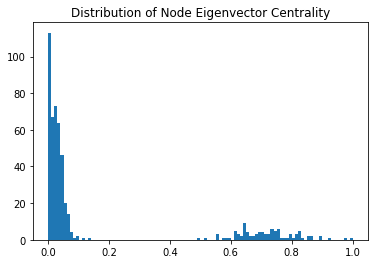

In [83]:
distributions(n10,'auto')

This model combines benefical aspects of the Proximity and Popularity models. The degree distribution is normal and has a resonable maximum that fits well with Dunbar's number, while the edge betweenness and eigenvector centralities have long tailed distributions while also exhibitting a more even distribution (ie higher average value) than the Proximity model. Additionally, the modularity of this model compares well with the modularity of the Proximity Model, which is designed to have high modularity.

## Conclusion:
The models used to represent social networks succeeded in reproducing observed phenomena. The proximity model was able to create strong groups after several iterations as seen by the modularity. The Popularity model produced long right-skewed distributions of edge betweenness and eigenvector centrality. However this model also produced right skewed degree distributions which do not make sense in the context of social networks. However, the Combination model, which used parts of both models was able to produce strong groups, sensible right-skewed edge betweenness and eigenvector centrality distributions and a roughly normal degree distribution. 
